# Topic Modeling with PySpark
In this notebook, I will use functions from `ml`, `sql`, and `spark-nlp` to build a topic modeling pipeline to analyze the topics in our copora from Personal Finance Reddit Posts.

In [1]:
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1622808589580_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version   
-------------------------- ----------
awscli                     1.19.87   
beautifulsoup4             4.9.3     
boto                       2.49.0    
botocore                   1.20.87   
click                      7.1.2     
colorama                   0.4.3     
docutils                   0.15.2    
jmespath                   0.10.0    
joblib                     0.17.0    
lxml                       4.6.1     
mysqlclient                1.4.2     
nltk                       3.5       
nose                       1.3.4     
numpy                      1.16.5    
pip                        9.0.1     
py-dateutil                2.2       
pyasn1                     0.4.8     
python-dateutil            2.8.1     
python37-sagemaker-pyspark 1.4.1     
pytz                       2020.1    
PyYAML                     5.3.1     
regex                      2020.10.28
rsa                        4.7.2     
s3transfer                 0.4.2     
setuptools  

In [2]:
sc.install_pypi_package("boto3") # use boto3 to see book data in S3 bucket
sc.install_pypi_package("seaborn")
sc.install_pypi_package("pandas")
sc.install_pypi_package("wordcloud")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
import boto3

from math import ceil
# tqdm provides a progress bar for iteration 
from tqdm.notebook import tqdm

from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import (
    StructType, StructField, StringType, DateType
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    CountVectorizer, RegexTokenizer,
    IDF, StopWordsRemover
)
from pyspark.ml.clustering import LDA
#Spark NLP
from sparknlp.annotator import *
from sparknlp.base import *
# plotting
from matplotlib import pyplot as plt
from wordcloud import WordCloud

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
sc

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<SparkContext master=yarn appName=livy-session-0>

In [7]:
params = dict(
    num_topics = 13,
    iterations = 10,
    vocabsize = 5000,
    minDF = 0.02,
    maxDF = 0.8
 )
params

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'num_topics': 13, 'iterations': 10, 'vocabsize': 5000, 'minDF': 0.02, 'maxDF': 0.8}

In [87]:
STOP_WORDS =['too', 'hence', 'give', 'never', 'without', "'m", 'something', "'s", 'well', 'hers', 'nine', 'off', 'noone', 'used', 'onto', 'to', 'much', 'us', 'via', 'less', 'had', 'anyone', 'neither', 'an', 'full', 'then', 'twenty', 'thereby', 'keep', 'yourself', 'thus', 'using', 'yourselves', 'each', 'which', 'how', 'doing', '’re', 'whereby', 'with', 'somewhere', 'name', 'that', 'otherwise', 'of', 'around', 'about', 'side', 'sometime', 'back', 'become', 'thru', 'ca', 'becoming', 'formerly', 'empty', 'not', 'often', 'such', 'very', 'therein', 'among', 'here', 'other', 'below', 'again', 'either', 'we', 'what', '’d', 'hereafter', 'ours', 'fifty', 'ourselves', 'your', 'front', 'by', 'upon', 'myself', 'or', 're', 'two', 'thence', 'hundred', 'anywhere', 'make', 'toward', 'towards', 'might', 'thereupon', 'should', 'forty', 'everything', 'me', 'unless', 'nevertheless', 'anyhow', 'former', 'behind', 'always', 'before', 'except', '‘ll', 'wherever', 'nowhere', 'first', 'do', 'move', 'any', 'say', 'been', 'who', 'at', 'also', 'themselves', 'somehow', 'can', 'will', '’s', 'wherein', 'least', 'namely', 'in', 'meanwhile', 'beyond', 'alone', 'moreover', 'and', 'due', 'himself', 'where', 'does', 'she', 'must', 'just', 'hereupon', 'herself', 'n‘t', 'being', 'under', "n't", 'why', 'another', 'during', 'his', 'no', "'ll", '’ve', 'everywhere', 'latterly', 'them', 'seems', 'would', 'next', 'this', 'put', 'third', 'made', 'together', 'as', 'enough', 'but', 'whole', 'you', 'rather', 'our', 'call', 'some', 'between', 'every', 'the', 'everyone', 'their', 'were', 'please', 'six', 'whose', 'perhaps', 'up', 'done', 'whom', 'thereafter', '‘ve', 'indeed', '‘s', 'twelve', '’m', 'sometimes', 'is', 'becomes', 'its', 'may', 'down', 'seemed', 'all', 'many', 'further', 'though', 'through', 'eight', 'are', 'became', 'they', 'yet', 'whither', 'against', 'cannot', 'bottom', 'whereafter', 'none', 'only', 'latter', 'since', 'else', 'was', 'more', 'various', 'serious', 'sixty', "'re", 'take', 'part', 'beside', 'most', 'ever', 'he', 'out', 'over', 'my', 'quite', 'however', "'d", 'because', 'already', 'on', 'four', 'nothing', 'n’t', 'whereas', 'has', 'once', 'top', 'seeming', 'within', 'regarding', 'almost', 'afterwards', 'both', 'per', 'several', 'seem', 'am', 'see', 'whatever', 'did', 'five', 'ten', 'yours', 'really', 'a', 'anything', '‘re', 'mine', 'still', 'elsewhere', 'whence', 'from', 'nor', 'him', 'last', 'her', 'while', 'hereby', 'eleven', 'itself', 'same', 'have', 'across', 'these', 'above', 'so', '‘m', 'therefore', 'than', "'ve", 'others', 'whenever', 'few', 'one', 'into', '‘d', 'get', 'amongst', 'if', 'anyway', 'whether', 'three', 'for', 'fifteen', 'after', 'nobody', 'amount', 'whereupon', 'whoever', 'could', 'it', 'when', 'someone', 'mostly', 'besides', 'although', 'now', 'go', 'until', 'i', 'own', 'herein', 'be', '’ll', 'show', 'throughout', 'even', 'there', 'beforehand', 'those', 'along']
extra_stopwords = ["i'm","don't", "i've", "www","r/personalfinance","don’t", "i", "it"]
STOP_WORDS += extra_stopwords

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [88]:
data = spark.read.csv('s3://large-scale-computing-personal-finance/raw-data/personalfinance_2020-01-01_2021-01-01.csv', 
                      header=True, 
                      sep=',', 
                      escape="\"", 
                      multiLine=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())
data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 78
Total Rows: 180299
root
 |-- all_awardings: string (nullable = true)
 |-- allow_live_comments: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_richtext: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: string (nullable = true)
 |-- author_premium: string (nullable = true)
 |-- awarders: string (nullable = true)
 |-- can_mod_post: string (nullable = true)
 |-- contest_mode: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- full_link: string (nullable = true)
 |-- gildings: string (nullable = true)
 |-- id: string (nullable = true)
 |-- is_crosspostable: string (nullable = true)
 |-- is_meta: string (nullable = true)
 |-- is_original_content: string (nullable = true)
 |-- is_redd

In [91]:
data = data[['selftext']].filter("selftext != '[removed]'")
data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            selftext|
+--------------------+
|So we have a Jeep...|
|I am about to pur...|
|I'm currently liv...|
|I don’t know anyt...|
|Basically a month...|
+--------------------+
only showing top 5 rows

In [33]:
texts=data.rdd.map(lambda x: x['selftext'])
texts=texts.zipWithIndex()
data = sqlContext.createDataFrame(texts, ["selftext",'index'])
type(data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

In [92]:
data.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

148253

# Preprocess Data

In [114]:
data = data.withColumn('selftext', f.lower(f.col('selftext'))).withColumn('words',f.split('selftext', ' '))
data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|            selftext|               words|
+--------------------+--------------------+
|so we have a jeep...|[so, we, have, a,...|
|i am about to pur...|[i, am, about, to...|
|i'm currently liv...|[i'm, currently, ...|
|i don’t know anyt...|[i, don’t, know, ...|
|basically a month...|[basically, a, mo...|
+--------------------+--------------------+
only showing top 5 rows

In [115]:
remover = (StopWordsRemover(
    inputCol="words", outputCol="words_filtered").setStopWords(STOP_WORDS))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [116]:
preprocPipeline = Pipeline(stages=[remover])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [117]:
wordsDF = preprocPipeline.fit(data).transform(data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [118]:
# build pipeline


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [119]:
# Concatenate list of words into a single word for downstream Spark-NLP pipeline
preprocDF = wordsDF.withColumn("words_joined", f.concat_ws(" ", "words_filtered"))
regex = r"[\!\(\)\-\[\]\{\}\;\:\'\"\\\,\<\>\.\/\?\@\#\$\%\^\&\*\_\~\']"
preprocDF = preprocDF.withColumn('words_joined',f.regexp_replace('words_joined', regex, '')) \
                     .withColumn('words_joined',f.regexp_replace('words_joined', r"\n", ' ')) \
                     .withColumn('words_joined',f.regexp_replace('words_joined', r" i ", '')) \
                     .withColumn('words_joined',f.regexp_replace('words_joined', r" it ", ''))

preprocDF.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+--------------------+
|            selftext|               words|      words_filtered|        words_joined|
+--------------------+--------------------+--------------------+--------------------+
|so we have a jeep...|[so, we, have, a,...|[jeep, grand, che...|jeep grand cherok...|
|i am about to pur...|[i, am, about, to...|[purchase, home,,...|purchase home clo...|
|i'm currently liv...|[i'm, currently, ...|[currently, livin...|currently living ...|
|i don’t know anyt...|[i, don’t, know, ...|[don’t, know, cre...|don’t know credit...|
|basically a month...|[basically, a, mo...|[basically, month...|basically month a...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [120]:
preprocDF.select('words_joined').take(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(words_joined='jeep grand cherokee average 20mpg owe 175k payments 420 month spoke trading smaller car substantial fuel gains iea diesel passat ones 1011 worth trade price little ttampl included gc pay off fuel mileage plus increased maintenance cost outweigh that ps good bit mileage vehicles vehicle truck paying rid regardless'), Row(words_joined='purchase home closing date april 1st home purchase price 455000 mortgage interest rate 325 30 year fixed family unit rented 1550month going room mate giving 500month    after mortgage taxes pmi insurance total monthly payment 3350 leaves responsible 1300month doable consider right bring 68k taxes month this overtime  here concerns bid 30000 asking very competitive market  bought height market concerned home values dropping  my overtime easily cut dropping 4500 home month  right rent extremely inexpensive area 975month split room mate responsible 575  would wise deal wait things level again  thank you'), Row(words_joined='currently living

## Spark-nlp Pipeline

In [121]:
def set_document_assembler(inputCol):
    "Spark NLP document assembler"
    return DocumentAssembler().setInputCol(inputCol)


def set_tokenizer(inputCol, outputCol):
    "Tokenize text for input to the lemmatizer"
    tokenizer = (Tokenizer()
        .setInputCols([inputCol])
        .setOutputCol(outputCol)
    )
    return tokenizer


def set_lemmatizer(inputCol, outputCol):
    "Retrieve root lemmas out of the input tokens"
    # Use default SparkNLP English pretrained lemmatizer for now
    lemmatizer = (LemmatizerModel.pretrained(name="lemma_antbnc", lang="en")
        .setInputCols([inputCol])
        .setOutputCol(outputCol)
    )
    return lemmatizer


def set_finisher(finishedCol):
    "Finisher transform for Spark NLP pipeline"
    finisher = (Finisher()
        .setInputCols([finishedCol])
        .setIncludeMetadata(False)
    )
    return finisher


def run_sparknlp_pipeline(df):
    """Create a SparkNLP pipeline that transforms the input DataFrame to procude a final output
       column storing each document as a sequence of lemmas (root words).
    """
    nlpPipeline = Pipeline(stages=[
        set_document_assembler("words_joined"),
        set_tokenizer("document", "token"),
        set_lemmatizer("token", "lemma"),
        set_finisher("lemma")
    ])
    nlpPipelineDF = (nlpPipeline.fit(df)
        .transform(df)
        .withColumnRenamed('finished_lemma', 'allTokens')
    )
    return nlpPipelineDF

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [122]:
nlpPipelineDF = run_sparknlp_pipeline(preprocDF)
nlpPipelineDF.select('allTokens').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
+--------------------+
|           allTokens|
+--------------------+
|[jeep, grand, che...|
|[purchase, home, ...|
|[currently, live,...|
|[don’t, know, cre...|
|[basically, month...|
+--------------------+
only showing top 5 rows

In [123]:
nlpPipelineDF.persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[selftext: string, words: array<string>, words_filtered: array<string>, words_joined: string, allTokens: array<string>]

## Spark ML Pipeline

In [124]:
def set_countvectorizer(inputCol, outputCol, params):
    countvectorizer = CountVectorizer(
        inputCol=inputCol,
        outputCol=outputCol,
        vocabSize=params['vocabsize'],
        minDF=params['minDF'],
        maxDF=params['maxDF'],
        minTF=1.0
    )
    return countvectorizer


def set_idf(inputCol, outputCol):
    return IDF(inputCol="features", outputCol="idf")


def set_lda_model(params):
    lda = LDA(
        k=params['num_topics'],
        maxIter=params['iterations'],
        optimizer="online",
        seed=1,
        learningOffset=100.0,  # If high, early iterations are downweighted during training
        learningDecay=0.51,    # Set between [0.5, 1) to guarantee asymptotic convergence
    )
    return lda


def run_ml_pipeline(nlpPipelineDF, params):
    """Create a Spark ML pipeline and transform the input NLP-transformed DataFrame 
       to produce a trained LDA topic model for the given data.
    """
    mlPipeline = Pipeline(
        stages=[
            set_countvectorizer("allTokens", "features", params),
            set_idf("features", "idf"),
            set_lda_model(params)
        ]
    )
    mlModel = mlPipeline.fit(nlpPipelineDF)
    ldaModel = mlModel.stages[2]
    # Calculate upper bound on model perplexity
    mlPipelineDF = mlModel.transform(nlpPipelineDF)
    ldaPerplexity = ldaModel.logPerplexity(mlPipelineDF)
    return mlModel, ldaPerplexity

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [125]:
mlModel, ldaPerplexity = run_ml_pipeline(nlpPipelineDF, params)
print("Upper bound on perplexity: {}".format(ldaPerplexity))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Upper bound on perplexity: 5.766380208123039

## Describe Topics

In [126]:
def describe_topics(mlModel):
    """Obtain topic words and weights from the LDA model.
       Returns: topics -> List[Dict[str, float]]
       A list of mappings between the top 15 topic words (str) and their weights
       (float) for each topic. The length of the list equals the number of topics.
    """
    # Store vocab from CountVectorizer
    vocab = mlModel.stages[0].vocabulary
    # Store LDA model part of pipeline
    ldaModel = mlModel.stages[2]

    # Take top 15 words in each topic
    topics = ldaModel.describeTopics(15)
    topics_rdd = topics.rdd

    topic_words = topics_rdd \
        .map(lambda row: row['termIndices']) \
        .map(lambda idx_list: [vocab[idx] for idx in idx_list]) \
        .collect()

    topic_weights = topics_rdd \
        .map(lambda row: row['termWeights']) \
        .collect()

    # Store topic words and weights as a list of dicts
    topics = [dict(zip(words, weights))
              for words, weights in zip(topic_words, topic_weights)]
    return topics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [127]:
topics = describe_topics(mlModel)
topics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[{'credit': 0.08713143057757938, 'card': 0.061091257426333985, 'pay': 0.03552086019216378, 'score': 0.021190387507940445, 'debt': 0.01594301572261432, 'month': 0.015409261525852773, 'year': 0.014822227250748894, 'account': 0.01424749482847296, 'payment': 0.01267026283802572, 'loan': 0.012257699600343506, 'balance': 0.011403129705337462, 'get': 0.010980660020947436, 'time': 0.007971559467694542, 'report': 0.007765660285930549, 'go': 0.007750125914045931}, {'know': 0.02324533714302992, 'ampx200b': 0.018533386652928023, 'like': 0.017939887142868212, 'pay': 0.016080676444415503, 'good': 0.013079751195184296, 'debt': 0.01263175850512337, 'help': 0.011874398974756844, 'money': 0.01143773375278896, 'work': 0.011207729494460916, 'time': 0.011129452982808132, 'business': 0.01050832467631634, 'want': 0.010507093449045142, 'it': 0.010159214140351161, 'find': 0.009223555259375049, 'credit': 0.008845120146838439}, {'tax': 0.04999990106960689, 'year': 0.03131001157179323, 'job': 0.030077478289967215

## Plot Topic WordClouds

In [128]:
def plot_wordclouds(topics, colormap="cividis"):
    cloud = WordCloud(
        background_color='white',
        width=600,
        height=400,
        colormap=colormap,
        prefer_horizontal=1.0,
    )

    num_topics = len(topics)
    fig_width = min(ceil(0.6 * num_topics + 6), 20)
    fig_height = min(ceil(0.65 * num_topics), 20)
    fig = plt.figure(figsize=(fig_width, fig_height))

    for idx, word_weights in tqdm(enumerate(topics), total=num_topics):
        ax = fig.add_subplot((num_topics / 5) + 1, 5, idx + 1)
        wordcloud = cloud.generate_from_frequencies(word_weights)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title('Topic {}'.format(idx + 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)

    plt.tick_params(labelsize=14)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.margins(x=0.1, y=0.1)
    st = fig.suptitle("LDA Topics", y=0.92)
#     fig.savefig("pyspark-topics.png", bbox_extra_artists=[st], bbox_inches='tight')
    plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [129]:
from tqdm import tqdm

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

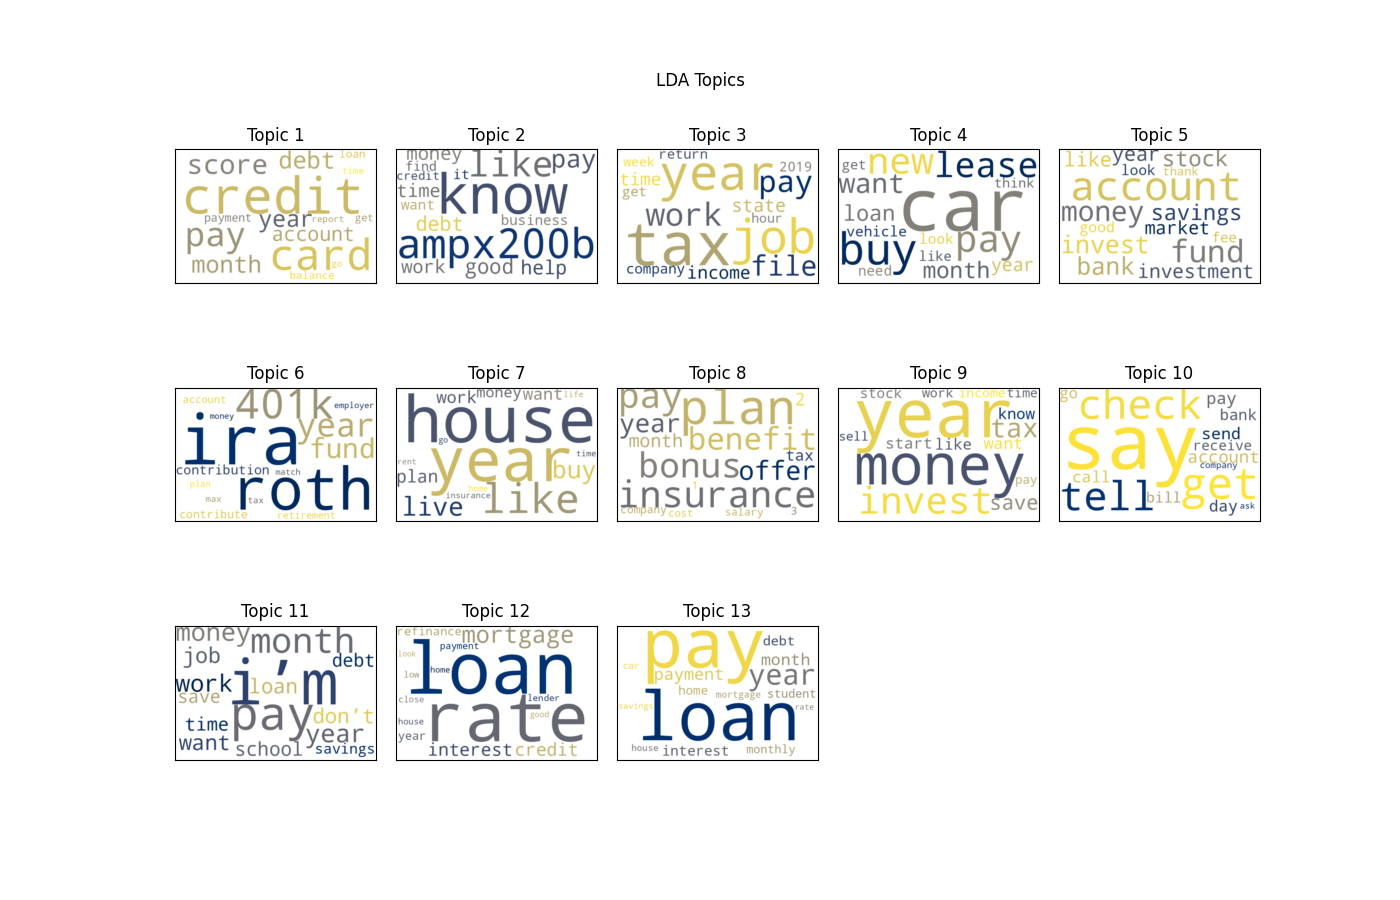

In [130]:
plt.close()
plot_wordclouds(topics)
%matplot plt